In [1]:
import pandas as pd
import polyline
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
# if we already have a separate data file with prepared summary polylines, can read like so:
# polylines = list(pd.read_csv("../data/chicago.csv")['summary_polyline'])

# otherwise, read json data that has a summary polyline field. 
# in this case, data comes from Strava API
df = pd.read_json('../data/friends_strava_data.txt')

# extract summary polyline from 'map' column, add index
df['summary_polyline'] = df.applymap(lambda x: x.get('summary_polyline', np.nan) \
                        if isinstance(x, dict) else np.nan)['map']
df = df[df['summary_polyline'] != ''] # get rid of activities with no summary polyline

# export data to use in heatmap generator website (one of my other projects) - this just helps us contextualize
# df[['name', 'start_date_local', 'type', 'distance', 'summary_polyline']].to_csv("friendTest.csv")

# separate out runs and rides
runs = df[df['type']=='Run']
run_polylines = list(runs['summary_polyline'])
rides = df[df['type']=='Ride']
ride_polylines = list(rides['summary_polyline'])

In [80]:
# design parameters
lineColor = '#FFFFFF' # stroke color
lineOpacity = 0.25 # stroke alpha value
lineWidth = 7.5 # stroke width
backgroundColor = '#001933' # we're not plotting on a normal map, because ~~art~~

In [118]:
def getNewPoint(startLat, startLon, bearing, distance):
    """
    use this to get bounding coordinates in a perfect square, since the final heatmap is a square
    but lat and long don't translate perfectly since earth is allegedly round
    
    Params:
    distance is in km
    if the goal is to get a perfect square, bearing should be:
        # -1.5708 = straight west. 1.5708 = straight east.
        # 0 = straight north, 3.1416 = straight south
    """
    
    R = 6378.1 # Radius of the Earth
    # bearing = -1.5708 # Bearing is 90 degrees converted to radians.

    lat1 = math.radians(startLat) #Current lat point converted to radians
    lon1 = math.radians(startLon) #Current long point converted to radians

    lat2 = math.asin( math.sin(lat1)*math.cos(distance/R) +
         math.cos(lat1)*math.sin(distance/R)*math.cos(bearing))

    lon2 = lon1 + math.atan2(math.sin(bearing)*math.sin(distance/R)*math.cos(lat1),
                 math.cos(distance/R)-math.sin(lat1)*math.sin(lat2))

    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return [lat2, lon2]

def clear_frame(ax=None): 
        # Taken from a post by Tony S Yu
        if ax is None: 
            ax = plt.gca() 
        ax.xaxis.set_visible(False) 
        ax.yaxis.set_visible(False) 
        for spine in ax.spines.values(): 
            spine.set_visible(False)
        
def plot_run_data(listOfPolylines, lineColor, lineOpacity, lineWidth, backgroundColor, southEastPoint, sideLength, outputFileName):
        """
        plots and saves an image of a heatmap
        params:
        - data: list of list or a dataframe, where each list or df row is GPS coordinates compiled in load_run_data()
        -lineColor: color of each GPX track
        -lineOpacity: how transparent each GPX track is
        -lineWidth: the stroke width for each GPX track
        -backgroundColor: color for heatmap's background, since we're not plotting on a traditional map
        -outputFileName: name of file heatmap image will be saved as 
        -minLat, maxLat, minLong, maxLong: dimensions for the map to help focus in on a specific area
        """

        # I used 80 x 80 for pictures I printed out into a 16" x 16" poster and it was perfect
        # you might need to mess around with these values for larger or bigger posters, and especially for non-square posters
        fig = plt.figure(figsize=(80,80)) 

        # convert summary polylines into lat and lon coordinates
        activityCount = 0
        main_df = pd.DataFrame({'lat':[], 'lon':[], 'activity':[]})

        for sp in listOfPolylines:
            data = polyline.decode(sp)
            df = pd.DataFrame(data)
            df.columns=['lat','lon']
            df['activity'] = activityCount

            if activityCount == 0:
                main_df = df
            else:
                main_df = pd.concat([main_df, df])

            activityCount += 1

        for i in main_df['activity'].unique():
            activity = main_df[main_df['activity'] == i]
            plt.plot(activity['lon'], activity['lat'], color=lineColor, linewidth=lineWidth, alpha=lineOpacity)

        ax = plt.gca()
        plt.grid(False)
        ax.patch.set_facecolor(backgroundColor)
        ax.set_aspect('auto','box','C')
        clear_frame()
        plt.subplots_adjust(left=0, right=1, top=1, bottom=.1)

        # these next few params are less design choices and more important for users with GPX files from multiple cities
        # to prevent your map from looking like a blank canvas with some random dots on it, you'll want focus your heatmap on any
        # given city by setting the plot boundaries as the city's min and max lat and long coordinates
        # optional: if run_data contains activities from multiple cities, focus your heatmap on any
        # given city by setting the plot boundaries as the citie's min and max long and lat coordinates
        northEast = getNewPoint(southEastPoint[0], southEastPoint[1], 0, distance) # due north of starting coordinates
        southWest = getNewPoint(southEastPoint[0], southEastPoint[1], -1.5708, distance) # due west of starting coordinates
        northWest = getNewPoint(southWest[0], southWest[1],  0, distance) # due north of starting coordinates
        
        bounds = pd.DataFrame([southEastPoint, northEast, southWest, northWest])
        minLat = bounds.min()[0]
        minLong = bounds.min()[1]
        maxLat = bounds.max()[0]
        maxLong = bounds.max()[1]
         
        # if boundary box inspection is needed, this is helpful    
        # plt.plot(bounds[1], bounds[0], color='red', linewidth = 30)
        
        plt.xlim((minLong, maxLong))
        plt.ylim((minLat, maxLat))
        
        plt.plot()

        plt.savefig(output_file_name, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format=None,
            transparent=False, bbox_inches='tight', pad_inches=0,
            metadata=None)

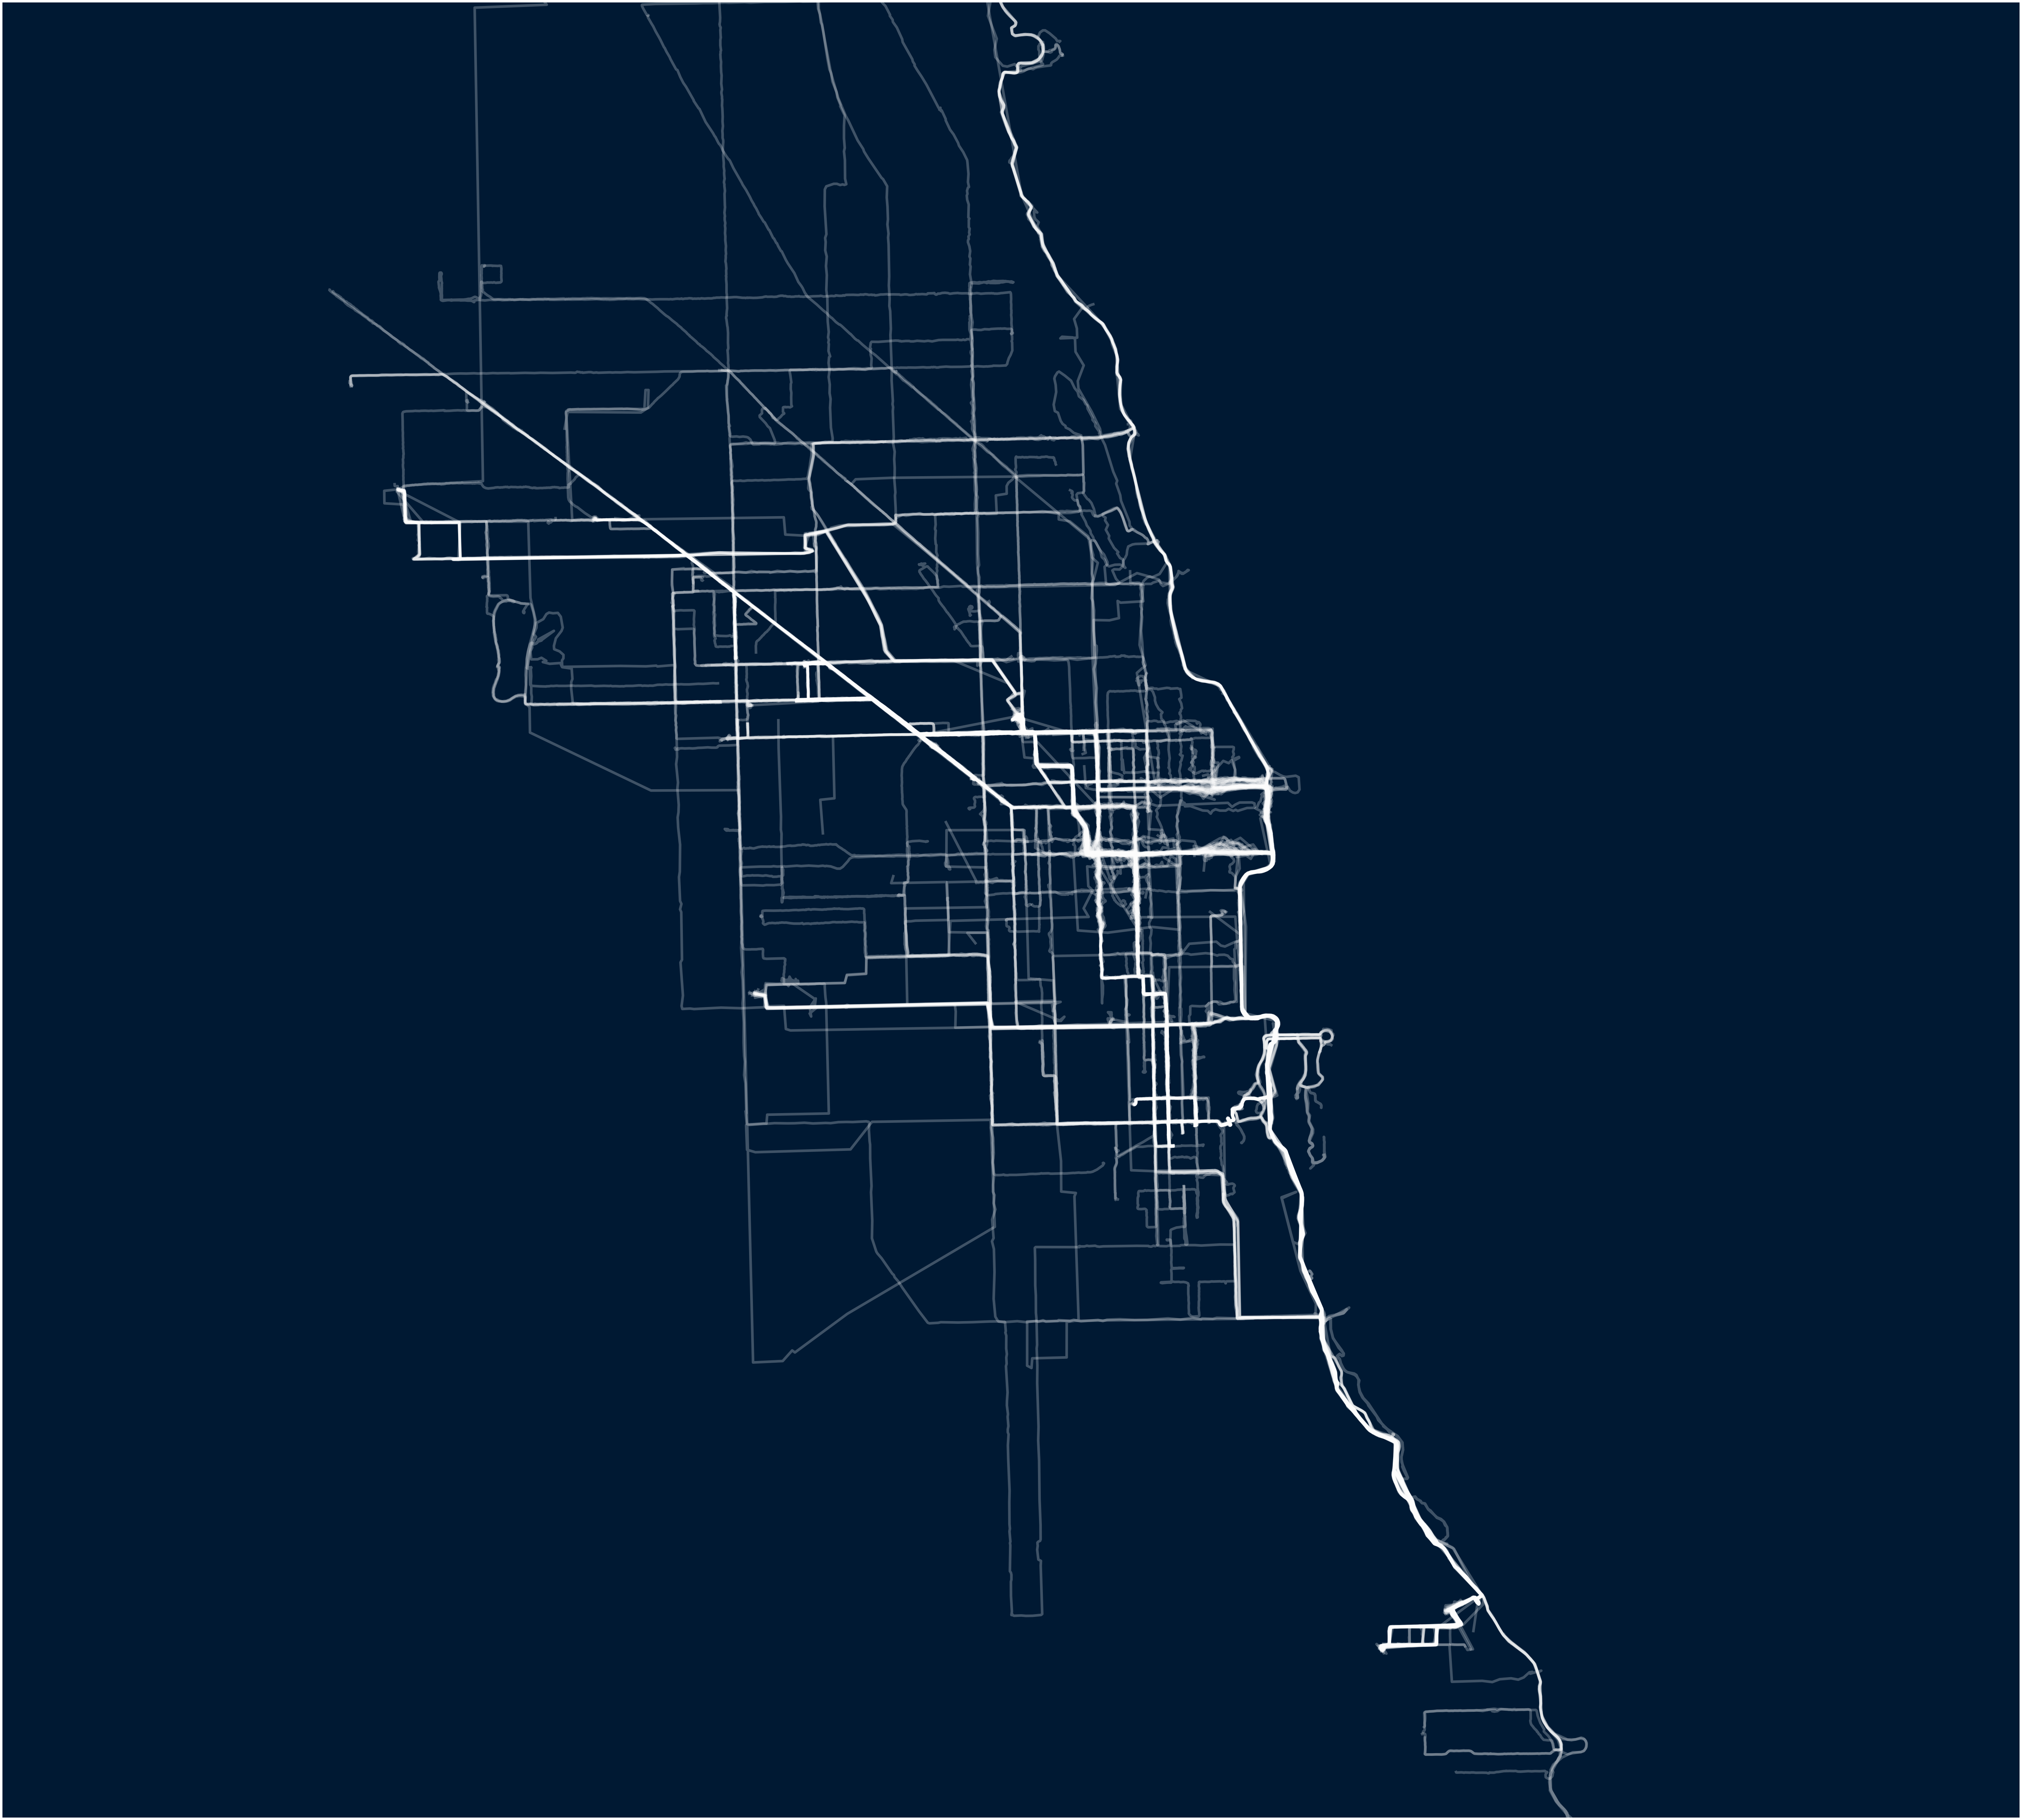

In [123]:
southEastCoordinate = [41.789179, -87.523927]
distance = 20 # distance between bounding points in km (aka how long is one side of the square)
output_file_name = 'ride_heatmap.png' # save heatmap under this name

plot_run_data(ride_polylines, lineColor, lineOpacity, lineWidth, backgroundColor, southEastCoordinate, distance, output_file_name)